# Upload your data

Do not forget that the data has to be in *csv* format!

In [41]:
import numpy as np
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
from collections import deque
from google.colab import files
from numpy import genfromtxt

# Upload a dataset in csv format
uploaded = files.upload()

Saving example2.csv to example2 (2).csv


# Utilities

This cell contains several utility functions to observe the results of compression. It helps us to visualize and see how effectively our method works.

In [0]:
def plot_compression(points, compressed_points):
  plt.plot(points[::2], points[1::2], 'b.');
  plt.plot(compressed_points[::2], compressed_points[1::2], 'gD-');
  plt.show()

# The weight between vertices u and v uses some properties of a line drawn
# between u and v. That's why we need to know its equation
def get_linear_coefs(G, u, v):
  # y = a * x + b
  a = (G.nodes[v]['y']-G.nodes[u]['y'])/(G.nodes[v]['x']-G.nodes[u]['x'])
  b = G.nodes[u]['y']-a*G.nodes[u]['x']
  return a, b

def node_accuracy(G, u, v, node, max_error):
  accuracy=0
  a, b = get_linear_coefs(G, u, v)
  accuracy=abs(G.nodes[node]['y']-(a*G.nodes[node]['x']+b))
  return accuracy

def line_accuracy(G, u, v, max_error):
  total_accuracy=0
  n_points=0
  for node in range(len(G.nodes)):
    if (G.nodes[node]['x']>=G.nodes[u]['x'] and 
        G.nodes[node]['x']<=G.nodes[v]['x']):
      total_accuracy+=node_accuracy(G, u, v, node, max_error)
      n_points+=1
  return total_accuracy/n_points

def compression_accuracy(G, compressed_points, max_error):
  total_accuracy=0
  n_lines=len(compressed_points)-1
  for i in range(n_lines):
    total_accuracy+=line_accuracy(G, 
                                  compressed_points[i], 
                                  compressed_points[i+1], 
                                  max_error)
  return total_accuracy/n_lines


# Dijkstra Algorithm

This cell contains Dijkstra's algorithm with backtracing support since we will need this functionality to be able to find the appropriate data points to compress the data set.

In [0]:
def get_min_dist_index(distances, ignored=[]):
  min_dist=max(distances)+1 # max(distances)+1
  min_dist_index=-1
  for i in range(len(distances)):
    if i not in ignored and min_dist>=distances[i]:
      min_dist=distances[i]
      min_dist_index=i
  return min_dist_index

def dijkstra(g,source,target,weight):
  queue=deque()
  dist=np.zeros(len(g.nodes))
  path=np.zeros(len(g.nodes), dtype=int)
  ignored=[source]
  for i in g:
    path[i]=source
    dist[i]=float("Inf")

  dist[source]=0
  queue.append(source)
  min_dist_node=0
  while queue:
    current=queue.popleft()
    if current==target:
      return [dist[target], path]
    for i in  g.neighbors(current):
      if dist[i]>dist[current]+g.edges[current,i][weight]:
        path[i]=current
        dist[i]=dist[current]+g.edges[current,i][weight]
    min_dist_node=get_min_dist_index(dist, ignored)
    # assert(min_dist_node>-1), "error!"
    ignored.append(min_dist_node)
    queue.append(min_dist_node)
  return None, None

# Backtracing nodes in order to find the most appropritate path
# between the nodes source and target
def backtrace_nodes(path, source, target):
  nodes=[target]
  current=path[target]
  nodes.append(current)
  while current!=source:
    current=path[current]
    nodes.append(current)
  return nodes[::-1]

# Graph declaration and initialization

All detailed information is given in the report!

In [0]:
# Distance between vertices u and v
def dist(G, u, v):
  return np.sqrt((G.nodes[u]['x']-G.nodes[v]['x'])**2 + 
                 (G.nodes[u]['y']-G.nodes[v]['y'])**2)

# Error at a point.
# If the point is not located between u and v then the error is 0.
# Otherwise, the error is the vertical distance between the point and 
# its corresponding y value
def error_at_point(G, u, v, point):
  if (G.nodes[point]['x']<G.nodes[u]['x'] or 
        G.nodes[point]['x']>G.nodes[v]['x']):
    return 0
  a, b = get_linear_coefs(G, u, v)
  real_value = a*G.nodes[point]['x']+b
  expected_value = G.nodes[point]['y']
  return abs(expected_value - real_value)

# The error of an edge is the maximum error among all errors at the points
# which are located between u and v
def error_of_edge(G, u, v):
  errors=[0]
  for node in G.nodes:
    if (G.nodes[node]['x']>G.nodes[u]['x'] and 
        G.nodes[node]['x']<G.nodes[v]['x']):
      errors.append(error_at_point(G, u, v, node))
  return max(errors)

# This function calculates the weight of an edge between vertices u and v.
# max_error is the parameter that we choose in order to set
# the maximum possible error value.
def weight_func(G, u, v, max_error):
  if max_error-error_of_edge(G, u, v)<=0:
    return 1000 # float("Inf")
  return 1/dist(G, u, v) # * np.sqrt((max_error-error_of_edge(G, u, v))))

# Initializes all the weights of graph G.
# Because G is a fully connected graph the number of edges is
# #nodes*(#nodes-1)/2.
def init_weights(G, max_error):
  for node in G.nodes:
    for neighbour in range(node+1, len(G.nodes)):
      value=weight_func(G, node, neighbour, max_error)
      G.add_edge(node, neighbour, weight=value)

# Creates a fully connected graph according to the given data.
# All weights are initialized and the returned graph is ready to use.
def create_graph(data, max_error=0.555):
  G=nx.Graph()
  # TO DO
  for i in range(len(data) // 2):
    G.add_node(i)
    attrs = {i: {'x': data[2*i], 'y': data[2*i+1]}}
    nx.set_node_attributes(G, attrs)
  init_weights(G, max_error)
  return G

# This function compressed the graph G for the vertices u and v.
# Returns the minimum distance and the corresponding shortest path.
def compress(G, u, v):
  dist, path = dijkstra(G, u, v, 'weight')
  compressed_nodes = backtrace_nodes(path, u, v)
  return compressed_nodes

# Prints out some useful metrics.
# If u is not given then it is replaced with the vertice located on the most
# left part of 2D sapce.
# If v is not given then it is replaced with the vertice located on the most
# right part of 2D space.
# If 'original_points' is provided it gives the plot of compression.
# If max_error is provided it prints the compression accuracy.
def print_metrics(G, u=None, v=None, original_points=[], max_error=None):
  if u==None:
    u=find_point(G, 'left')
  if v==None:
    v=find_point(G, 'right')
  compressed_nodes=compress(G, u, v)

  print("Compressed points:", end=" ")
  for node in compressed_nodes:
    print(node, end=" ")
  print("\nCompression Degree:", 1-(len(compressed_nodes)-2)/(len(G.nodes)-2))

  if len(original_points)!=0:
    if max_error!=None:
      print("Compression Accuracy:", compression_accuracy(G, 
                                                          compressed_nodes, 
                                                          max_error))
    compressed_points=np.zeros(2*len(compressed_nodes))
    for i, node in enumerate(compressed_nodes):
      compressed_points[2*i]=G.nodes[node]['x']
      compressed_points[2*i+1]=G.nodes[node]['y']
    plot_compression(original_points, compressed_points)

def find_point(G, attr):
  sign=1
  x_value=G.nodes[0]['x']
  node_index=0
  if attr=='left':
    sign=-1
  for node in G.nodes:
    if x_value*sign<G.nodes[node]['x']*sign:
      x_value=G.nodes[node]['x']
      node_index=node
  return node_index

# Example

This example data set is called '*example2.csv*'. It is simple and covers for the most part of the project as you will see this example in the report too. In the report we have theoretically found what is bad and good compression for this data set and here by implementing our method, we still show the same results as we had in our report. 

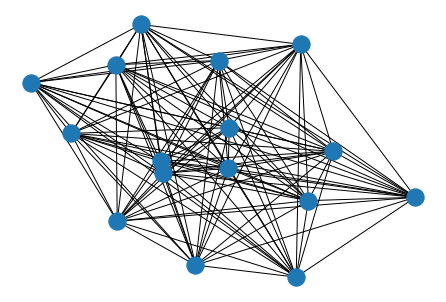

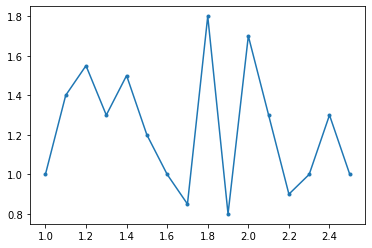

Compressing [0-15]
Compressed points: 0 4 15 
Compression Degree: 0.9285714285714286
Compression Accuracy: 0.20268939393939395


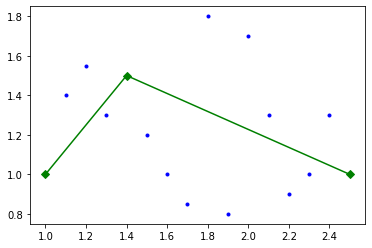

In [45]:
# Loading data points from csv file
data_points = genfromtxt('example2.csv', delimiter=',')

# Putting all 2D positions in 1D numpy array as [x0 y0 x1 y1 ... xn yn]
data=np.zeros((2*len(data_points)))
for index, value in enumerate(data_points):
  data[2*index]=value[0]
  data[2*index+1]=value[1]

# Setting a maximum error value
max_error=0.555

G = create_graph(data, max_error)
nx.draw(G)
plt.show()
plt.plot(data[::2], data[1::2], '.-');
plt.show()

print("Compressing [0-15]")
# This function automatically compresses the data points.
# Then prints some useful information such as what the selected points are
# or what is the summation of weights crossing through them.
# Not all the metrics given in the report is printed out since they are
# just to understand the method itself.
print_metrics(G, 0, 15, data, max_error)